<h1>C4 Solution</h1>

<h3>Install and import</h3>

In [1]:
%%capture
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

In [2]:
import os
import boto3
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics

<h3>Get the data and copy it to S3</h3>

In [12]:
%%capture
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip
!aws s3 cp dogImages s3://proj-4/ --recursive

<h3>Set up parameters, estimator, and tuner</h3>

In [3]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [4]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=1,
    max_parallel_jobs=1,  # you once have one ml.g4dn.xlarge instance available
    objective_type=objective_type
)

<h3>Fit the tuner</h3>

In [5]:
os.environ['SM_CHANNEL_TRAINING']='s3://proj-4/'
os.environ['SM_MODEL_DIR']='s3://proj-4/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://proj-4/output/'
tuner.fit({"training": "s3://proj-4/"})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...................................................................................................................................................................................................................................................!


<h3>Describe the tuning results</h3>


In [45]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-230316-2328-001-db379ba6')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


ClientError: An error occurred (ValidationException) when calling the ListTrainingJobsForHyperParameterTuningJob operation: 2 validation errors detected: Value 'pytorch-training-230316-2328-001-db379ba6' at 'hyperParameterTuningJobName' failed to satisfy constraint: Member must have length less than or equal to 32; Value 'pytorch-training-230316-2328-001-db379ba6' at 'hyperParameterTuningJobName' failed to satisfy constraint: Member must satisfy regular expression pattern: ^[a-zA-Z0-9](-*[a-zA-Z0-9]){0,31}

## Imp: If kernel dies, how to continue from a completed training job

In [46]:
#BetterTrainingJobName='pytorch-training-210623-2156-001-fdd5e081'
#my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)
#my_estim.ator.hyperparameters()
#best_estimator=my_estimator

<h3>Prepare to perform Training on Best Estimator</h3>

In [6]:
best_estimator=tuner.best_estimator()


2023-03-17 11:22:23 Starting - Preparing the instances for training
2023-03-17 11:22:23 Downloading - Downloading input data
2023-03-17 11:22:23 Training - Training image download completed. Training in progress.
2023-03-17 11:22:23 Uploading - Uploading generated training model
2023-03-17 11:22:23 Completed - Resource retained for reuse


In [7]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'learning_rate': '0.014568731688936784',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"hpo-2023-03-17-11-02-18-011"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-051150398741/hpo-2023-03-17-11-02-18-011/source/sourcedir.tar.gz"'}

In [8]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}
hyperparameters

{'batch_size': 32, 'learning_rate': '0.014568731688936784'}

In [9]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [10]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

<h2>Creating an Estimator</h2>

In [53]:
#adjust this cell to accomplish multi-instance training
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='mn',
    role=role,
    instance_count=1,
    instance_type='ml.g4dn.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [54]:
estimator.fit({"training": "s3://proj-4/"}, wait=False)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: mn-2023-03-17-00-3

<h2>Creating an Estimator - Multi-Instance Training,</h2>

In [11]:
###in this cell, create and fit an estimator using multi-instance training
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='mn2',
    role=role,
    instance_count=2,
    instance_type='ml.c4.2xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)
estimator.fit({"training": "s3://proj-4/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: mn2-2023-03-17-11-23-02-926


2023-03-17 11:23:03 Starting - Starting the training job...
2023-03-17 11:23:33 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-03-17 11:24:34 Downloading - Downloading input data......
2023-03-17 11:25:34 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-17 11:25:30,731 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-17 11:25:30,735 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2023-03-17 11:25:30,747 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-17 11:25:30,749 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-03-17 11:25:30,912 sagemaker-

<h2>Deployment</h2>

In [12]:
model_location=estimator.model_data


In [13]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [14]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [15]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='infernce2.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [16]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker:Creating model with name: pytorch-inference-2023-03-17-11-39-05-142
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-03-17-11-39-05-908
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-03-17-11-39-05-908


-----!

In [17]:
import requests
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

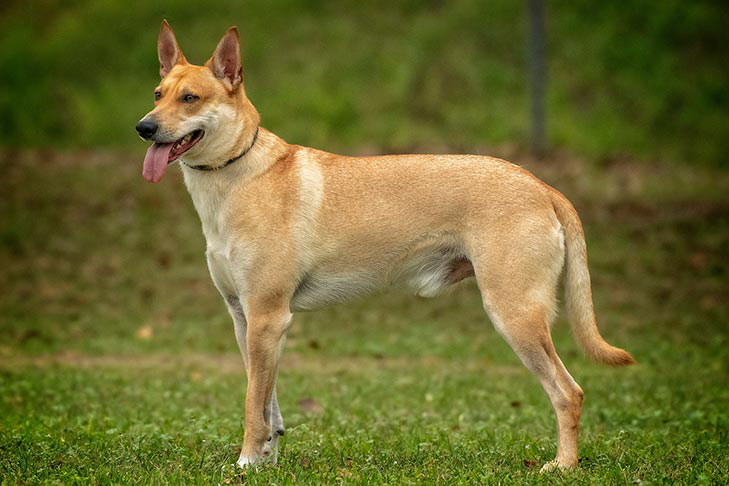

In [18]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [19]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [20]:
import json
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [21]:
type(response2[0][0])

float

In [22]:
response2[0]

[0.141860231757164,
 0.19246408343315125,
 0.11054784059524536,
 -0.44145721197128296,
 -0.3768511116504669,
 -0.7856472134590149,
 0.14952100813388824,
 0.36615848541259766,
 -0.27677658200263977,
 -0.05652252584695816,
 0.21839722990989685,
 0.18091653287410736,
 -0.057400885969400406,
 0.430167555809021,
 0.3148767948150635,
 0.3036029636859894,
 0.30216577649116516,
 -0.06260722875595093,
 -0.06053672358393669,
 0.2470693737268448,
 -0.8611360788345337,
 -0.4691133499145508,
 0.28794991970062256,
 0.08496476709842682,
 -0.06413575261831284,
 -0.14502692222595215,
 0.3156021237373352,
 -0.10148391872644424,
 0.06388045847415924,
 0.20754948258399963,
 0.07834699004888535,
 0.3021090626716614,
 -0.12887336313724518,
 0.2606751322746277,
 0.0749618262052536,
 0.22513224184513092,
 0.12180879712104797,
 0.26441311836242676,
 0.3248705565929413,
 0.23801289498806,
 0.387273371219635,
 0.11377397179603577,
 -0.2130422443151474,
 0.2630731761455536,
 0.08501054346561432,
 0.42023569345474

In [23]:
import torch
import numpy as np
np.argmax(response, 1)

array([86])

In [24]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-03-17-11-39-05-908
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-03-17-11-39-05-908
